# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scipy.stats as stats

from sklearn import linear_model

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import statsmodels
import plotly.express as px

event_folder = '/Users/erichganz/Documents/Master Thesis/investment data'
reg_folder   = '/Users/erichganz/Documents/Master Thesis/Regression Folder'

#
#Load company data and tieseries
comp_data_eval       = pd.read_excel('/Users/erichganz/Documents/Master Thesis/Data/tolookup.xlsx', index_col=0)
timeseries_short     = pd.read_excel('/Users/erichganz/Documents/Master Thesis/Data/timeseries_short.xlsx', index_col=0)
timeseries_middle    = pd.read_excel('/Users/erichganz/Documents/Master Thesis/Data/timeseries_middle.xlsx', index_col=0)
timeseries_long      = pd.read_excel('/Users/erichganz/Documents/Master Thesis/Data/timeseries_long.xlsx', index_col=0)
timeseries_very_long = pd.read_excel('/Users/erichganz/Documents/Master Thesis/Data/timeseries_very_long.xlsx', index_col=0)

def code_to_time(code, extension = ''):

    foundation = int(comp_data_eval.loc[comp_data_eval.Code == code].FoundationYear)
    if foundation   >= 2018: return timeseries_short[[f'{code}{extension}']][str(foundation) + '-01-01':]
    elif foundation >= 2015: return timeseries_middle[[f'{code}{extension}']][str(foundation) + '-01-01':]
    elif foundation >= 2012: return timeseries_long[[f'{code}{extension}']][str(foundation) + '-01-01':]
    else:                    return timeseries_very_long[[f'{code}{extension}']][str(foundation) + '-01-01':]

# Variance Testing

In [55]:
def f_test_var(series_1, series_2):

    # Compute f-statistic and degrees of freedom
    f, df1, df2 = np.var(series_1, ddof=1)/np.var(series_2, ddof=1), len(series_1) - 1, len(series_2) - 1

    return float(f), float(stats.f.cdf(f, df1, df2))

## For Adjusted Time Periods

In [60]:
for index_good_time, row in comp_data_eval.iterrows():

    # Load residuals
    input_data = '_resid_ARIMA'
    data       = code_to_time(row.Code, input_data)

    # Events
    events     = pd.read_excel(f'{reg_folder}/{row.Name}.xlsx')
    events.set_index(events.Date, inplace = True)
    events.drop(['Date'], axis=1, inplace=True)

    # List of event dates including start and end of timeline
    points_in_time = events.loc[events.Event.isna()].index.union([data.index[0], data.index[-1]])[::-1]
    
    # P-values storage
    p_value_f_test, p_value_levene, p_value_bartlett, j = [], [], [], 0

    for i in range(len(events)):

        # if event is a media event
        if events.iloc[i,:].Event == events.iloc[i,:].Event:
            p_value_f_test.append(np.nan)
            p_value_levene.append(np.nan)
            p_value_bartlett.append(np.nan)
            continue

        # Get relevant points of the period of interest
        interval_1 = points_in_time[j+1] - points_in_time[j+2]
        breakpoint = points_in_time[j+1]
        interval_2 = points_in_time[j] - points_in_time[j+1]
        start      = points_in_time[j+2]
        end        = points_in_time[j]

        if interval_1.days < 100 or interval_2.days < 100:
            p_value_f_test.append(np.nan)
            p_value_levene.append(np.nan)
            p_value_bartlett.append(np.nan)
            j+=1
            continue

        # if periods are too Long
        if interval_1.days > 300: start = breakpoint - pd.Timedelta(days = 300)
        if interval_2.days > 300: end   = breakpoint + pd.Timedelta(days = 300)

        # Get relevant interval/period
        interval_1 = data[start: breakpoint][f'{row.Code}{input_data}'].tolist()
        interval_2 = data[breakpoint: end][f'{row.Code}{input_data}'].tolist()
            
        p_value_f_test.append(f_test_var(interval_1, interval_2)[1])
        p_value_levene.append(stats.levene(interval_1, interval_2)[1])
        p_value_bartlett.append(stats.bartlett(interval_1, interval_2)[1])
        
        j+=1
        
    # Add statistic to the table
    events['F_test_p_value_ARIMAresid_TPadjusted']   = p_value_f_test
    events['Levene_p_value_ARIMAresid_TPadjusted']   = p_value_levene
    events['Bartlett_p_value_ARIMAresid_TPadjusted'] = p_value_bartlett

    # Save results
    events.to_excel(f'{reg_folder}/{row.Name}.xlsx')


/Users/erichganz/Library/Python/3.8/lib/python/site-packages/scipy/stats/_morestats.py:2468: RuntimeWarning:

divide by zero encountered in log

/Users/erichganz/Library/Python/3.8/lib/python/site-packages/scipy/stats/_morestats.py:2468: RuntimeWarning:

divide by zero encountered in log

/Users/erichganz/Library/Python/3.8/lib/python/site-packages/scipy/stats/_morestats.py:2468: RuntimeWarning:

divide by zero encountered in log

/Users/erichganz/Library/Python/3.8/lib/python/site-packages/scipy/stats/_morestats.py:2468: RuntimeWarning:

divide by zero encountered in log

/var/folders/95/03l6lh_j2fj5qfcb_7_xdn5w0000gn/T/ipykernel_53092/4121666608.py:4: RuntimeWarning:

invalid value encountered in double_scalars

/Users/erichganz/Library/Python/3.8/lib/python/site-packages/scipy/stats/_morestats.py:2604: RuntimeWarning:

invalid value encountered in double_scalars

/Users/erichganz/Library/Python/3.8/lib/python/site-packages/scipy/stats/_morestats.py:2468: RuntimeWarning:

divide by z

## Legacy From Event to Event

In [ ]:
min_peiod = 56
max_peiod = 356

for index_good_time, row in comp_data_eval.iterrows():

    # Load residuals
    input_data = '_resid_ARIMA'
    data       = code_to_time(row.Code, input_data)

    # Events
    events     = pd.read_excel(f'{reg_folder}/{row.Name}.xlsx')
    events.set_index(events.Date, inplace = True)
    events.drop(['Date'], axis=1, inplace=True)

    # List of event dates including start and end of timeline
    points_in_time = events.loc[events.Event.isna()].index.union([data.index[0], data.index[-1]])[::-1]
    
    # P-values storage
    p_value_f_test, p_value_levene, p_value_bartlett, j = [], [], [], 0

    for i in range(len(events)):

        if events.iloc[i,:].Event == events.iloc[i,:].Event:

            p_value_f_test.append(np.nan)
            p_value_levene.append(np.nan)
            p_value_bartlett.append(np.nan)
            continue
        
        try:

            # Get relevant points of the period of interest
            start, breakpointa, breakpointb, end = points_in_time[j+2], points_in_time[j+1], points_in_time[j+1], points_in_time[j]
            interval_1, interval_2 = breakpointa - start, end - breakpointb

            # if periods are too short
            k = j+3
            while interval_1.days < min_peiod:
                        
                breakpointa = start
                start = points_in_time[k]
                interval_1 = breakpointa - start
                k += 1
            
            k = j-1
            while interval_2.days < min_peiod:
                        
                breakpointb = end
                end = points_in_time[k]
                interval_2 = end - breakpointb
                k -= 1
            
            # if periods are too Long
            if interval_1.days > max_peiod:

                days = interval_1.days - max_peiod
                start = start + pd.Timedelta(days = days)
                interval_1 = breakpointa - start
            
            if interval_2.days > max_peiod:

                days = interval_2.days - max_peiod
                end = end - pd.Timedelta(days = days)
                interval_2 = end - breakpointb

            # Get relevant interval/period
            interval_1 = data[start: breakpointa][f'{row.Code}{input_data}'].tolist()
            interval_2 = data[breakpointb: end][f'{row.Code}{input_data}'].tolist()
                
            p_value_f_test.append(f_test_var(interval_1, interval_2)[1])
            p_value_levene.append(stats.levene(interval_1, interval_2)[1])
            p_value_bartlett.append(stats.bartlett(interval_1, interval_2)[1])
        
        except: 

            p_value_f_test.append(np.nan)
            p_value_levene.append(np.nan)
            p_value_bartlett.append(np.nan)
            continue

        j+=1


    # Add statistic to the table
    events['F_test_p_value_ARIMAresid_TPadjusted']   = p_value_f_test
    events['Levene_p_value_ARIMAresid_TPadjusted']   = p_value_levene
    events['Bartlett_p_value_ARIMAresid_TPadjusted'] = p_value_bartlett

    # Save results
    events.to_excel(f'{reg_folder}/{row.Name}.xlsx')

In [535]:
for index_good_time, row in good_time.iterrows():

    # Load residuals
    input_data = '_resid_ARIMA'
    data       = code_to_time(row.gtCode, input_data)

    # Events
    events     = pd.read_excel(f'{reg_folder}/{row.CompanyName}.xlsx')
    events.set_index(events.Date, inplace = True)
    events.drop(['Date'], axis=1, inplace=True)

    # List of event dates including start and end of timeline
    points_in_time = events.loc[events.Event.isna()].index.union([data.index[0], data.index[-1]])[::-1]
    
    # P-values storage
    p_value_f_test, p_value_levene, p_value_bartlett, j = [], [], [], 0

    for i in range(len(events)):

        if events.iloc[i,1] == events.iloc[i,1]:

            p_value_f_test.append(np.nan)
            p_value_levene.append(np.nan)
            p_value_bartlett.append(np.nan)
            continue

        # Get relevant interval/period
        interval_1 = data[points_in_time[j+2]: points_in_time[j+1]][f'{row.gtCode}{input_data}'].tolist()
        interval_2 = data[points_in_time[j+1]: points_in_time[j]][f'{row.gtCode}{input_data}'].tolist()

        if len(interval_1) < 8 or len(interval_2) < 8:

            p_value_f_test.append(np.nan)
            p_value_levene.append(np.nan)
            p_value_bartlett.append(np.nan)
    
        else:
            
            # Get p-values
            p_value_f_test.append(f_test_var(interval_1, interval_2)[1])
            p_value_levene.append(stats.levene(interval_1, interval_2)[1])
            p_value_bartlett.append(stats.bartlett(interval_1, interval_2)[1])

        j+=1


    # Add statistic to the table
    events['F_test_p_value_ARIMAresid_longTP']   = p_value_f_test
    events['Levene_p_value_ARIMAresid_longTP']   = p_value_levene
    events['Bartlett_p_value_ARIMAresid_longTP'] = p_value_bartlett

    # Save results
    events.to_excel(f'{reg_folder}/{row.CompanyName}.xlsx')

# Structural Changes Test

In [325]:
time = ['2020-06-18', '2020-03-17', '2018-03-23', '2020-04-15',
               '2019-12-16', '2019-02-11', '2017-06-21', '2019-03-25',
               '2015-05-06', '2014-11-08', '2016-12-09']

time = [pd.Timestamp(date) for date in time]

names = ['Mapillary', 'Babylon Health', 'PolyAI', 'Onfido', 'Habana Labs',
       'Nuro', 'Cybereason', 'Dynamic Yield', 'Affirm', 'SenseTime',
       'MEGVII']

event_type = ['Acquired', 'Incubator/Accelerator - II', 'Seed', 'Series D',
       'Acquired', 'Series B', 'Series D', 'Acquired', 'Series C',
       'Series A', 'Series C']

In [364]:
import math


def displacement(a,b):

    dist = math.hypot(b - a)

    if b >= a:

        return dist
    
    return - dist

In [470]:
from math import atan2
from math import degrees

def chow_test_structure_both(df, withevents, breakpoint, name, namecomp):

    df = sm.add_constant(df)
    df = statsmodels.tsa.tsatools.add_trend(df, trend='t')

    df['const_dummy'] = (df.index >= breakpoint).astype(int)
    df['trend_dummy'] = [0] * (df.shape[0] - df['const_dummy'].sum()) + list(range(1,np.sum(df['const_dummy'])+1)) 
    
    # df['const_dummy'] * df['trend']

    model_u = sm.OLS(df[f'{name}'], df.drop(name, axis=1)).fit()

    
    if namecomp == 'Affirm' and breakpoint == pd.Timestamp('2021-01-13'):

        df['unrestricted'] = model_u.predict()
    
        print(model_u.pvalues.const, model_u.pvalues.trend, model_u.pvalues.const_dummy, model_u.pvalues.trend_dummy)

        df[f'{name}'] = withevents
        
        fig = px.line(df, x=df.index, y=[f'{name}', 'unrestricted'], title= f'{namecomp} - Dissimilar regression After IPO', labels={'company': 'Interest', 'date': 'Time since founding'})
        fig.add_vline(x=breakpoint, line_width=1, line_dash="dash", line_color="red")

        fig.show()
    
    
    return model_u.pvalues.const, model_u.pvalues.trend, model_u.pvalues.const_dummy, model_u.pvalues.trend_dummy
    
def chow_test_structure_inter(df, withevents, breakpoint, name, namecomp):

    df = sm.add_constant(df)
    df = statsmodels.tsa.tsatools.add_trend(df, trend='t')

    df['const_dummy'] = (df.index >= breakpoint).astype(int)

    model_u = sm.OLS(df[f'{name}'], df.drop([f'{name}'], axis=1)).fit()
    
    df['unrestricted'] = model_u.predict()

    
    if namecomp == 'Zymergen' and breakpoint == pd.Timestamp('2020-09-08'):
    
        print(model_u.pvalues.const, model_u.pvalues.trend, model_u.pvalues.const_dummy)

        df[f'{name}'] = withevents
        #{event_type[names.index(namecomp)]
        
        fig = px.line(df, x=df.index, y=[f'{name}', 'unrestricted'], title= f'{namecomp} - Parallel Regression After Series A', labels={'company': 'Interest', 'date': 'Time since founding'})
        fig.add_vline(x=breakpoint, line_width=1, line_dash="dash", line_color="red")

        fig.show()
    

def chow_test_structure_slope(df, withevents, breakpoint, name, namecomp):

    df = sm.add_constant(df)
    df = statsmodels.tsa.tsatools.add_trend(df, trend='t')

    df['const_dummy'] = (df.index >= breakpoint).astype(int)
    df['trend_dummy'] = [0] * (df.shape[0] - df['const_dummy'].sum()) + list(range(1,np.sum(df['const_dummy'])+1))

    model_u = sm.OLS(df[f'{name}'], df.drop([f'{name}', 'const_dummy'], axis=1)).fit()
    
    df['unrestricted'] = model_u.predict()

    old_angle = degrees(atan2(model_u.params.trend, 1))
    new_angle = degrees(atan2(model_u.params.trend+model_u.params.trend_dummy, 1))

    
    if namecomp == 'Graphcore' and breakpoint == pd.Timestamp('2017-11-13'):
    
        print(model_u.pvalues.trend_dummy, model_u.params.trend, model_u.params.trend_dummy, old_angle,new_angle, displacement(old_angle, new_angle))

        #df[f'{name}'] = withevents
        #{event_type[names.index(namecomp)]

        fig = px.line(df, x=df.index, y=[f'{name}', 'unrestricted'], title= f'{namecomp} - Concurent Regressiob After Series C', labels={'company': 'Interest', 'date': 'Time since founding'})
        fig.add_vline(x=breakpoint, line_width=1, line_dash="dash", line_color="red")

        fig.show()
    

In [471]:
for index_good_time, row in comp_data_eval.iterrows():

    # Load residuals
    input_data = '_no_seasonality'
    data       = code_to_time(row.Code, input_data)
    withevents = code_to_time(row.Code, '_no_seasonality')

    # Events
    events     = pd.read_excel(f'{event_folder}/{row.Name}.xlsx')
    events.set_index(events.Date, inplace = True)
    events.drop(['Date'], axis=1, inplace=True)

    # List of event dates including start and end of timeline
    points_in_time = list(events.loc[events.Event.isna()].index.union([data.index[0], data.index[-1]])[::-1])
    
    # P-values storage
    p_val_inters, p_val_slops, p_val_inter_bs, p_val_slop_bs, j, change_slope, change_inter = [], [], [], [], 0, [], []
   
    for i in range(len(events)):

        # if event is a media event
        if events.iloc[i,:].Event == events.iloc[i,:].Event:
            p_val_inters.append(np.nan)
            p_val_slops.append(np.nan)
            p_val_inter_bs.append(np.nan)
            p_val_slop_bs.append(np.nan)
            #change_slope.append(np.nan)
            #change_inter.append(np.nan)
            continue

        # Get relevant points of the period of interest
        interval_1 = points_in_time[j+1] - points_in_time[j+2]
        breakpoint = points_in_time[j+1]
        interval_2 = points_in_time[j] - points_in_time[j+1]
        start      = points_in_time[j+2]
        end        = points_in_time[j]

        if interval_1.days < 100 or interval_2.days < 100:
            p_val_inters.append(np.nan)
            p_val_slops.append(np.nan)
            p_val_inter_bs.append(np.nan)
            p_val_slop_bs.append(np.nan)
            #change_slope.append(np.nan)
            #change_inter.append(np.nan)
            j+=1
            continue

        # if periods are too Long
        if interval_1.days > 300: start = breakpoint - pd.Timedelta(days = 300)
        if interval_2.days > 300: end   = breakpoint + pd.Timedelta(days = 300)

        
        #Make chow test
        chow_test_structure_inter(data[start + pd.Timedelta(days = 7):end - pd.Timedelta(days = 7)], withevents[start + pd.Timedelta(days = 7):end - pd.Timedelta(days = 7)], breakpoint, f'{row.Code}{input_data}', row.Name)
        chow_test_structure_slope(data[start + pd.Timedelta(days = 7):end - pd.Timedelta(days = 7)], withevents[start + pd.Timedelta(days = 7):end - pd.Timedelta(days = 7)], breakpoint, f'{row.Code}{input_data}', row.Name)
        p_val_inter, p_val_slop, p_val_inter_b, p_val_slop_b = chow_test_structure_both(data[start + pd.Timedelta(days = 7):end - pd.Timedelta(days = 7)], withevents[start + pd.Timedelta(days = 7):end - pd.Timedelta(days = 7)], breakpoint, f'{row.Code}{input_data}', row.Name)
        
        #collect results of chow
        p_val_inters.append(p_val_inter)
        p_val_slops.append(p_val_slop)
        p_val_inter_bs.append(p_val_inter_b)
        p_val_slop_bs.append(p_val_slop_b)
        #change_slope.append(slope)
        #change_inter.append(inter)
        
        j+=1
        
    # Save results
    events['p_val_con']   = p_val_inters
    events['p_val_slop']    = p_val_slops
    events['p_val_con_d'] = p_val_inter_bs
    events['p_val_slop_d']  = p_val_slop_bs
    #events['change_slope']  = change_slope
    #events['change_inter']  = change_inter

    #events.to_excel(f'{reg_folder}/{row.Name}.xlsx')

6.525871688828876e-06 2.9890022889471813e-15 1.473906544977835e-15 3.0048809601380363e-13


0.0007003038867565792 1.1654342370134119 -1.423442517864385 49.368780444644464 -14.46727319616283 -63.83605364080729


1.6569172660614326e-09 0.0016336809061544587 0.007772537080787678


### visualization of struc changes

In [ ]:
i = 0
for index, comp in events.iterrows():


    code = comp_data_eval.loc[comp_data_eval.Name == comp.comp_name].Code.values[0]
    start       = time_points[i][0]
    breakpointa = time_points[i][1]
    breakpointb = time_points[i][2]
    end         = time_points[i][3]

    interval = code_to_time(code, '_no_events')
    full_in  = interval[start:end]
    interval = pd.concat([interval[start:breakpointa],interval[breakpointb:end]], axis=0)

    interval = sm.add_constant(interval)
    interval = statsmodels.tsa.tsatools.add_trend(interval, trend='t')

    interval['const_dummy'] = (interval.index >= breakpointa).astype(int)

    a = [0] * (interval.shape[0] - interval['const_dummy'].sum())
    a.extend(list(range(1,interval['const_dummy'].sum()+1)))

    interval['trend_dummy'] = a

    y   = interval[f'{code}_no_events']
    x_r = interval[['const', 'trend']]
    x_u = interval[['const', 'trend', 'const_dummy', 'trend_dummy']]

    model_r = sm.OLS(y,x_r).fit()
    model_u = sm.OLS(y,x_u).fit()

    df                 = interval
    df['unrestricted'] = model_u.predict()
    df['restricted']   = model_r.predict()

    intervall = code_to_time(code, '')

    df['original'] = intervall[start:end]


    fig = px.line(df, x=df.index, y=[f'original', 'unrestricted', 'restricted', ], title= f'{comp.comp_name} - {comp.Chow_p_value}', labels={'company': 'Interest', 'date': 'Time since founding'})
    fig.add_vline(x=comp.picked_date, line_width=1, line_dash="dash", line_color="red")

    fig.show()
    print(model_u.summary())

    i += 1

# Lenght of Periods Between VC Events

In [30]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(event_folder) if isfile(join(event_folder, f)) and f != '.DS_Store']

In [31]:
all_time_deltas = []

for index, row in comp_data_eval.iterrows():

    events = pd.read_excel(f'{event_folder}/{row.Name}.xlsx')

    time_deltas = []

    for index, row in events.iterrows():

        if len(time_deltas) != 0: time_deltas[-1] = time_deltas[-1] - row.Date

        if len(time_deltas) == len(events) -1: continue

        time_deltas.append(row.Date)

    if any([a.days in [5,6,7] for a in time_deltas]): print(row.comp_name)

    all_time_deltas.extend(time_deltas)



Subtle Medical


In [40]:
100/7, 300/7

(14.285714285714286, 42.857142857142854)

In [41]:
72*7

504

In [49]:
all_periods = pd.DataFrame([obj.days/7 for obj in all_time_deltas])
all_periods.describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9])

,0
count,705.000000
mean,45.937791
std,35.548520
min,1.000000
10%,7.828571
20%,14.000000
30%,20.200000
40%,28.800000
50%,37.000000
60%,47.914286


In [54]:
(14+	72.685714)/2

43.342857

In [ ]:
all_periods

In [139]:
all_periods.median()

0    259.0
dtype: float64

In [10]:
np.mean(all_periods)[0]

45.93779128672746

/Users/erichganz/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'



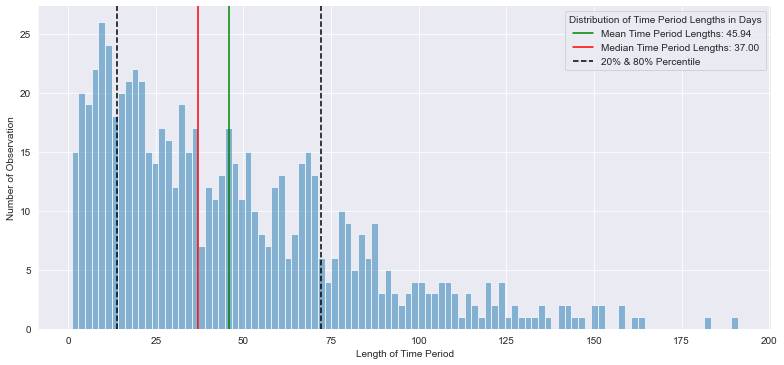

In [51]:
import seaborn as sb
sb.set_style("darkgrid")

# Distribution of p values of zscores among events 
dis_plot = sb.displot(all_periods, bins=100, legend=False, height=5, aspect=2.2)

mean, median = np.mean(all_periods)[0], np.median(all_periods)

plt.axvline(mean, 0,400, color='g')
plt.axvline(median, 0,400, color='r')
plt.axvline(14, 0 ,400, color='black', linestyle='dashed')
plt.axvline(72, 0,400, color='black', linestyle='dashed')

plt.legend(title='Distribution of Time Period Lengths in Weeks', loc='upper right', labels=[f'Mean Time Period Lengths: {"{:.2f}".format(mean)}', f'Median Time Period Lengths: {"{:.2f}".format(median)}', f'20% & 80% Percentile'])
dis_plot.set(xlabel='Length of Time Period', ylabel='Number of Observation')
plt.show(dis_plot)

In [52]:
dis_plot.savefig("/Users/erichganz/Documents/Master Thesis/Visual/timeperiodleght.png") 

# Predict Breakpoint

# Regression Legacy

In [ ]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd  = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput) 

In [ ]:
for code in good_time.gtCode.values:

    print(code)
    
    df = code_to_time(code, '_no_events')

    df['first_diff'] = df[f'{code}_no_events'] - df[f'{code}_no_events'].shift(1)

    test_stationarity(df.first_diff.dropna())

    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = statsmodels.graphics.tsaplots.plot_acf(df.first_diff.iloc[1:], lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = statsmodels.graphics.tsaplots.plot_pacf(df.first_diff.iloc[1:], lags=40, ax=ax2)
    

In [514]:
data = code_to_time('/g/11f006dwxx'	, '_no_events')
data.index = pd.DatetimeIndex(data.index.values, freq='W')
model = ARIMA(data, order=(1, 1, 2))

model = model.fit()

import plotly.express as px


code = '/g/11f006dwxx'	
name = comp_data_eval.loc[comp_data_eval.gtCode == code].values[0][0]
df   = code_to_time(code, '_no_events')
y    = df[f'{code}_no_events']

df['Prediction'] = model.predict().shift(-1)

fig = px.line(df, x=df.index, y=df.columns[:], title= f'{name}', labels={code: 'Interest', 'date': 'Time since founding'})
fig.update_xaxes(rangeslider_visible=True)

events = pd.read_excel(f'/Users/erichganz/Documents/Master Thesis/investment data/{name}.xlsx')
'''
for i in events.iterrows():

    # For events 
    if i[1].Funding != i[1].Funding: fig.add_vline(x=i[1].Date, line_width=1, line_dash="dash", line_color="green")
    # For Fundings 
    else:                            fig.add_vline(x=i[1].Date, line_width=1, line_dash="dash", line_color="red")

'''
fig.show()

/Users/erichganz/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/erichganz/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

